In [1]:
import warnings as _wrn
_wrn.filterwarnings('always')

In [2]:
import sys as _sys
import pickle as _pkl
import itertools as _itr

import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_plt.style.use('ggplot')

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap_external.py:412: ImportWarning: Not importing directory /Users/dimitris/Venvs/py35/lib/python3.5/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap_external.py:412: ImportWarning: Not importing directory /Users/dimitris/Venvs/py35/lib/python3.5/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap_external.py:412: ImportWarning: Not importing directory /Users/dimitris/Venvs/py35/lib/python3.5/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap_external.py:412: Import

In [3]:
import eQTLseq as _assoc

In [4]:
# def fcn(fname):
#     counts = _pnd.read_table(fname, index_col=0).values
#     counts = counts[counts.sum(1)>0, :]  # remove zero-sum rows
#     fit = _assoc.fit_nbinom_model(counts)
#     print('{} genes did not converge'.format((~fit['converged']).sum()), file=_sys.stderr)
#     idxs = (fit['converged']) & (_nmp.log(fit['phi']) > -10)
#     pars = {'mu': fit['mu'][idxs], 'phi': fit['phi'][idxs]}

#     _plt.figure(figsize=(15,10))
#     _plt.subplot(2,2,1); _plt.hist(_nmp.log(pars['mu']), 100); _plt.xlabel('mean')
#     _plt.subplot(2,2,2); _plt.hist(_nmp.log(pars['phi']), 100); _plt.xlabel('dispersion');
#     _plt.subplot(2,2,3); _plt.loglog(pars['mu'], pars['mu'] + pars['mu']**2 / pars['phi'], '.', markersize=0.5); _plt.xlabel('mean'); _plt.ylabel('variance');    

#     return pars

# ##
# pars = fcn('data/montpick_count_table_CEU.txt')
pars = _pnd.read_table('data/pars.txt', sep=',')
MAF = _nmp.loadtxt('data/G1000.chr1.freq.txt')

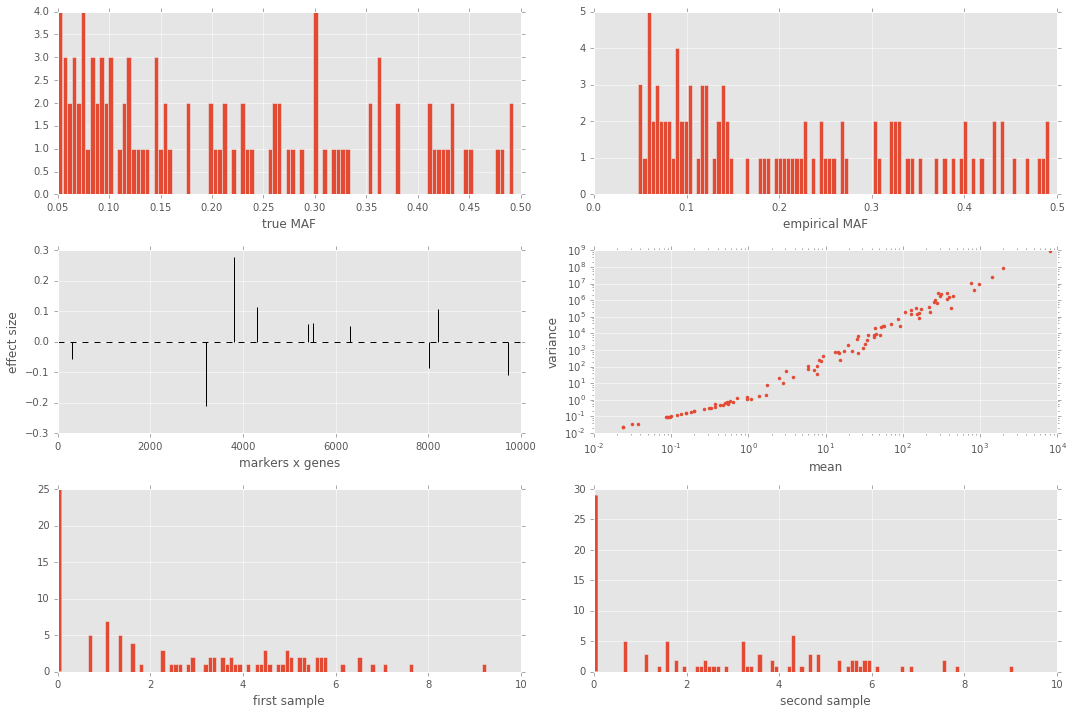

In [257]:
def fcn(n_samples=1000, n_markers=100, n_genes=100, MAF=MAF, n_eQTLs=0, hot=(1,10), poly=(0,10), 
        size=2, pois=0.0, outliers=0.0):
    data_geno = _assoc.simulate_genotypes(MAF, n_samples, n_markers)
    data_pheno = _assoc.simulate_eQTLs(data_geno['G'], pars['mu'].values, pars['phi'].values, n_genes=n_genes, 
                                       n_eQTLs=n_eQTLs, hot=hot, poly=poly, size=size, pois=pois, 
                                       outliers=outliers)

    _plt.figure(figsize = (15,10));
    _plt.subplot(3,2,1); _plt.hist(data_geno['MAF'], 100); _plt.xlabel('true MAF')
    _plt.subplot(3,2,2); _plt.hist(data_geno['G'].sum(0) / (2 * n_samples), 100); _plt.xlabel('empirical MAF')
#     _plt.subplot(3,2,3); _plt.imshow(data_pheno['beta'], cmap=_plt.cm.gray); _plt.xlabel('markers'); _plt.ylabel('genes')
    _plt.subplot(3,2,3); _plt.vlines(range(n_markers * n_genes), 0, data_pheno['beta'].ravel()); 
    _plt.axhline(linestyle='--', color='k'); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')
    _plt.subplot(3,2,4); _plt.loglog(data_pheno['mu'], data_pheno['mu'] + data_pheno['mu']**2 / data_pheno['phi'], '.'); _plt.xlabel('mean'); _plt.ylabel('variance');
    _plt.subplot(3,2,5); _plt.hist(_nmp.log(data_pheno['Z'][:,0]+1), 100); _plt.xlabel('first sample');
    _plt.subplot(3,2,6); _plt.hist(_nmp.log(data_pheno['Z'][:,1]+1), 100); _plt.xlabel('second sample');
    _plt.tight_layout()
    
    return {**data_geno, **data_pheno}

##
data = fcn()

In [287]:
_rnd.seed(0)
Z = data['Z'] / _assoc.calculate_norm_factors(data['Z'])
# Z = _assoc.transform_data(Z, kind='log')
res = _assoc.run(Z, data['G'], n_iters = 1000, mdl='NBinomial4', scale=True, n_threads=1)

Starting...
Iteration 1000 of 1000
Done!


([1.7566309864871084, 0.20000000000000001, 0.0, 2, 0, 9990, 8],
 0.16216702223225724)

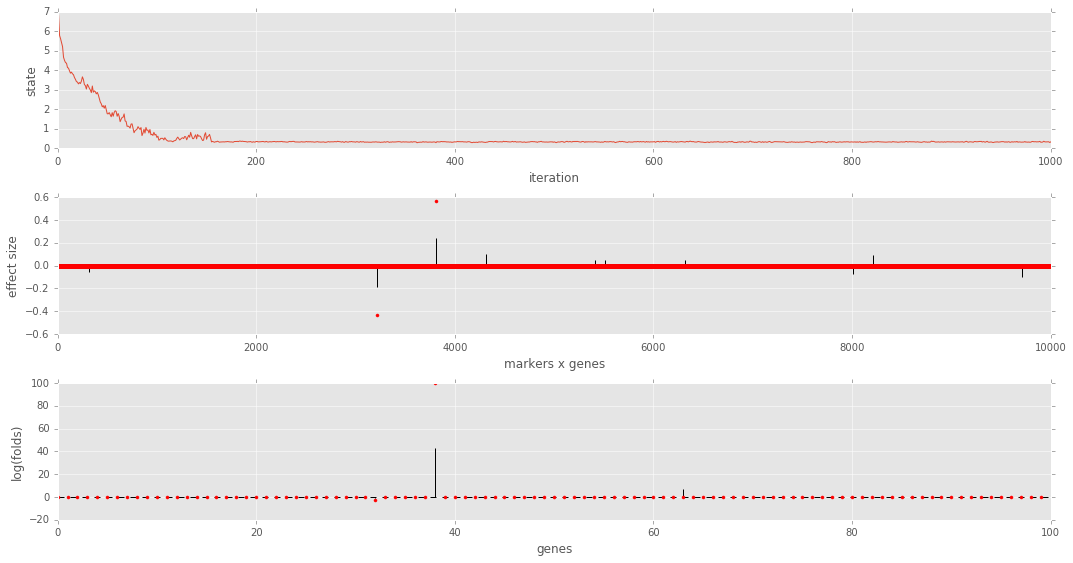

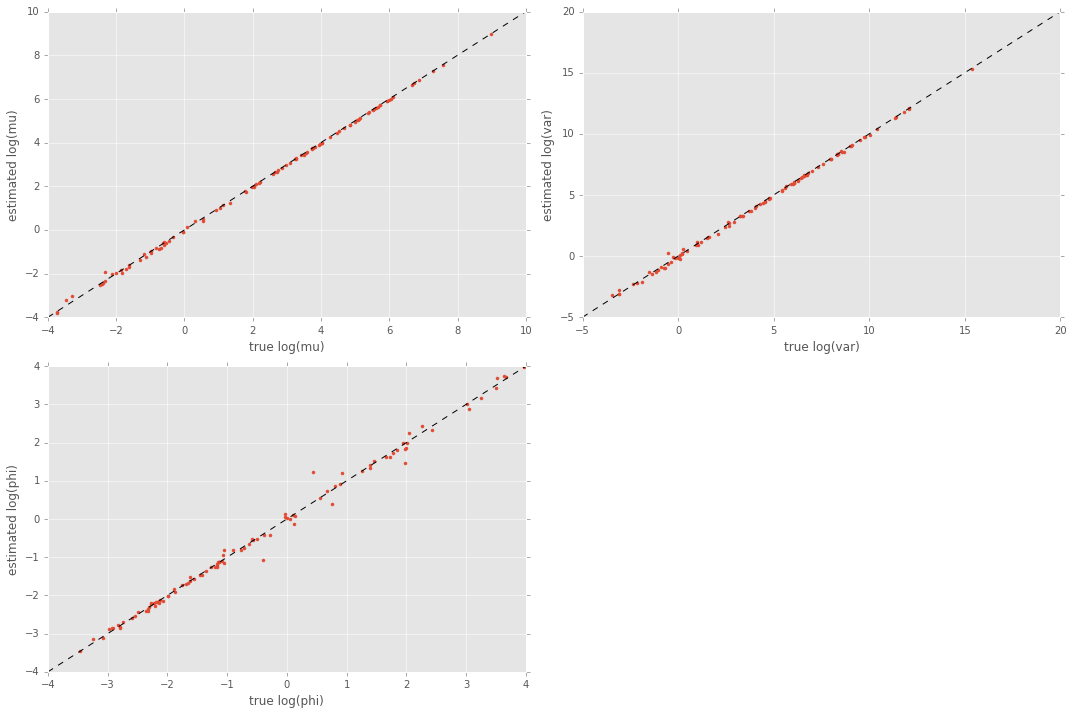

In [288]:
def fcn():
    _plt.figure(figsize = (15,10));
    _plt.subplot(4,1,1); _plt.plot(res['state']); _plt.xlabel('iteration'); _plt.ylabel('state')

    beta_estim = res['beta'] / _nmp.abs(res['beta']).sum()
    beta_true = data['beta'] / _nmp.abs(data['beta']).sum()
    n_genes, n_markers = beta_true.shape

    _plt.subplot(4,1,2); 
    _plt.vlines(range(n_markers * n_genes), 0, beta_true.ravel()); 
    _plt.axhline(linestyle='--', color='k');
    _plt.plot(beta_estim.ravel(), 'r.'); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')

    if 'mu' in res:
        G = data['G']
    #     G = (G - _nmp.mean(G, 0)) / _nmp.std(G, 0)
        folds_true = _nmp.mean(G.dot(beta_true.T), 0) * data['mu']
        folds_estim = _nmp.mean(G.dot(beta_estim.T), 0) * res['mu']
        n_samples, _ = G.shape
        _plt.subplot(4,1,3); 
        _plt.vlines(range(n_genes), 0, folds_true.ravel()); 
        _plt.axhline(linestyle='--', color='k');
        _plt.plot(folds_estim.ravel(), 'r.'); _plt.xlabel('genes'); _plt.ylabel('log(folds)')
    
    if 'Y' in res:
        _plt.subplot(4,1,4); 
        _plt.plot(res['Y'].ravel(), 'r.'); _plt.xlabel('genes'); _plt.ylabel('log(folds)')
        _plt.axhline(linestyle='--', color='k');

    _plt.tight_layout()
        
    if 'mu' in res:
        _plt.figure(figsize = (15,10))
        _plt.subplot(2,2,1)
        _plt.plot(_nmp.log(data['mu']), _nmp.log(res['mu']), '.'); _plt.ylim(_plt.xlim()); 
        _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
        _plt.xlabel('true log(mu)'); _plt.ylabel('estimated log(mu)')

        if 'phi' in res:
            var_tru = data['mu'] + data['phi'] * data['mu']**2
            var_est = res['mu'] + res['phi'] * res['mu']**2
            
            _plt.subplot(2,2,2)
            _plt.plot(_nmp.log(var_tru), _nmp.log(var_est), '.'); _plt.ylim(_plt.xlim()); 
            _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
            _plt.xlabel('true log(var)'); _plt.ylabel('estimated log(var)')

            _plt.subplot(2,2,3)
            _plt.plot(_nmp.log(data['phi']), _nmp.log(res['phi']), '.'); _plt.ylim(_plt.xlim()); 
            _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
            _plt.xlabel('true log(phi)'); _plt.ylabel('estimated log(phi)')
                        
    _plt.tight_layout()

    return _assoc.calculate_metrics(res['beta'], data['beta'])

##
metrics = fcn()
[metrics[_] for _ in ['RSS', 'TPR', 'FDR', 'TP', 'FP', 'TN', 'FN']], metrics['MCC']/(metrics['RSS'] + 1)

In [289]:
G = (data['G'] - _nmp.mean(data['G'], 0)) / _nmp.std(data['G'], 0)
folds = _nmp.exp(G.dot(data['beta'].T))
_nmp.min(folds), _nmp.max(folds)

(0.59112728727239916, 2.0)